# Twitter Complaints

The sentiment analysis model aims to solve the real-world problem of tracking and analyzing customer feedback for businesses. Customer complaints and negative sentiment can have a significant impact on a company's reputation and bottom line. By identifying the top 10 companies with the most complaints, stakeholders can proactively address the underlying issues that are leading to negative feedback and improve the overall customer experience.

The stakeholders who could use this project include company executives, customer service teams, marketing teams, and product development teams. Company executives could use the insights from the sentiment analysis to make strategic decisions about customer experience and company direction. Customer service teams could use the data to improve response times and address customer issues more efficiently. Marketing teams could use the insights to craft targeted messaging that addresses customer concerns, while product development teams could use the feedback to identify areas for improvement.

The sentiment analysis model would provide stakeholders with valuable information, including the top companies with the most complaints, the average response times of these companies, and the change in sentiment on clients after interacting with these companies. This information would help stakeholders to identify areas for improvement and take proactive measures to improve customer satisfaction, loyalty, and overall business performance.

## Intalling Packages and Imports

In [1]:
!pip install vaderSentiment
!pip install neattext
!pip install textblob

In [5]:
#Hide Warnings
import warnings
warnings.filterwarnings('ignore')

In [79]:
#EDA Pkgs
import pandas as pd
import numpy as np

# Data Viz Pkg
import matplotlib.pyplot as plt
import seaborn as sns

#Text pkg
import neattext.functions as nfx

#Python imports
import string
import re
import nltk
from collections import Counter
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')  
from nltk.corpus import stopwords
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Sentiment Pkg
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


#LDA Related Pkgs
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel

# LDA visualization
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt

C:\Users\apalaciosvillagom\.conda\conda\envs\learn-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\apalaciosvillagom\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\apalaciosvillagom\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!


True

### Loading Dataset

This data set has over 1 million rows filled with information on tweets wich will be used in the mosty infficient way in order to create meaningfull insight that will help companies take correct decision in terms of consumer and customer support interactions.

Dataset features:

tweet_id : A unique, anonymized ID for the Tweet. Referenced by response_tweet_id and in_response_to_tweet_id.

author_id : A unique, anonymized user ID. @s in the dataset have been replaced with their associated anonymized user ID.

ainbound : Whether the tweet is "inbound" to a company doing customer support on Twitter. This feature is useful when re-organizing data for training conversational models.

created_at : Date and time when the tweet was sent.

text : Tweet content. Sensitive information like phone numbers and email addresses are replaced with mask values like email.

response_tweet_id : IDs of tweets that are responses to this tweet, comma-separated.

in_response_to_tweet_id : ID of the tweet this tweet is in response to, if any.

In [9]:
#Load Dataset
df = pd.read_csv("twcs.csv")

# Reformatting Dataframe

    - Matching tweet to company
    - Dividing each tweet inbound in to its inidvidual category such as (customer tweets, customer response tweets and 
      company tweets)

In this section all tweet "conversations" from 2 to 4 tweets inclouding responses, this is done becouse there is not always a clear answer from the company in the first response so we keep loger conversations in order to lababel each tweet better.

In [10]:
#Code outputs in inbound tweet, and 3 responding tweets, as well as companies.
df_resp = df[['created_at','tweet_id','author_id','text','in_response_to_tweet_id', 'response_tweet_id']]

# Recolecting all customer inbound tweets and first responses by merging left.
inbound = df[pd.isnull(df.in_response_to_tweet_id) & df.inbound == True]
inbound = inbound[['created_at','tweet_id','text','response_tweet_id', 'in_response_to_tweet_id']]
df2 = pd.merge(inbound, df_resp, how = 'left', left_on='tweet_id', right_on='in_response_to_tweet_id')
df2 = df2[['created_at_x','text_x', 'tweet_id_y','author_id','created_at_y','text_y']]

# Recolecting the all responses to first response. 
df3 = pd.merge(df2, df_resp, how = 'left', left_on='tweet_id_y', right_on='in_response_to_tweet_id')
df3 = df3[['created_at_x', 'text_x','author_id_x', 'created_at_y', 'text_y','created_at','tweet_id', 'author_id_y','text']]
df3.rename(columns={'created_at_x':'inbound_time','text_x': 'inbound_text', 'author_id_x': 'author_1','created_at_y':'resp_1_time', 'text_y' : 'text1',\
                   'author_id_y':'author_2', 'created_at':'resp_2_time', 'text':'text2'}, inplace=True)

# Saving 2 Tweet conversations in a dataset.
first_resp = df3[df3.tweet_id.isnull()]
first_resp.rename(columns = {'author_1': 'company'}, inplace = True)
first_resp = first_resp.iloc[:,:-4]

# 3. Recolecting third responses.
df3 = df3[df3.tweet_id.notnull()]
df4 = pd.merge(df3, df_resp, how = 'left', left_on='tweet_id', right_on='in_response_to_tweet_id')
df4 = df4[['inbound_time','inbound_text','author_1','resp_1_time', 'text1','resp_2_time',\
           'author_2','text2','created_at', 'tweet_id_y','author_id','text']]
df4.rename(columns = {'author_id': 'author_3', 'text':'text3', 'created_at': 'resp_3_time'},inplace = True)

# Saving 3 tweet conversations in new df
second_resp = df4[df4.tweet_id_y.isnull()]
second_resp = second_resp.iloc[:,:-4]
second_resp['company'] = ''
for count in second_resp.index:
    for i in ['author_1','author_2']:
        if second_resp[i][count].isnumeric() == False:
            second_resp['company'][count] = second_resp[i][count]

# 4. Recolecting 4th responses.
df4 = df4[df4.tweet_id_y.notnull()]
df5 = pd.merge(df4, df_resp, how = 'left', left_on='tweet_id_y', right_on='in_response_to_tweet_id')
df5 = df5[['inbound_time','inbound_text','author_1','resp_1_time', 'text1','author_2', 'resp_2_time', 'text2','author_3','resp_3_time', 'text3',\
          'author_id','created_at', 'text','tweet_id']]
df5.rename(columns = {'author_id': 'author_4', 'created_at':'resp_4_time', 'text':'text4'},inplace = True)

# Saving 4 tweet conversations in new df
third_resp = df5[df5.tweet_id.isnull()]
third_resp = third_resp.iloc[:,:-4]
third_resp['company'] = ''
for count in third_resp.index:
    for i in ['author_1','author_2','author_3']:
        if third_resp[i][count].isnumeric() == False:
            third_resp['company'][count] = third_resp[i][count]

Creating a Dataframe with inbound label with related company name

In [11]:
# Creating a dataframe with (company, text and tweet type).

inbound1 = pd.concat([first_resp[['inbound_time','inbound_text','company']], second_resp[['inbound_time','inbound_text','company']]\
          ,third_resp[['inbound_time','inbound_text','company']]])
inbound1.rename(columns = {'inbound_text':'text', 'inbound_time':'time'}, inplace = True)
inbound1['type'] = 'inbound'

comp_tweet0 = first_resp[['resp_1_time','company','text1']]
comp_tweet0.rename(columns = {'text1':'text', 'resp_1_time':'time'}, inplace = True)

comp_tweet1 = second_resp[second_resp.author_1.apply(lambda x: x.isnumeric()== False)][['resp_1_time','company','text1']]
comp_tweet1.rename(columns = {'text1':'text','resp_1_time':'time'}, inplace = True)
comp_tweet2 = second_resp[second_resp.author_2.apply(lambda x: x.isnumeric()== False)][['resp_2_time','company','text2']]
comp_tweet2.rename(columns = {'text2':'text', 'resp_2_time':'time'}, inplace = True)

comp_tweet3 = third_resp[third_resp.author_1.apply(lambda x: x.isnumeric()== False)][['resp_1_time', 'company','text1']]
comp_tweet3.rename(columns = {'text1':'text', 'resp_1_time':'time'}, inplace = True)
comp_tweet4 = third_resp[third_resp.author_2.apply(lambda x: x.isnumeric()== False)][['resp_2_time', 'company','text2']]
comp_tweet4.rename(columns = {'text2':'text','resp_2_time':'time'}, inplace = True)
comp_tweet5 = third_resp[third_resp.author_3.apply(lambda x: x.isnumeric()== False)][['resp_3_time', 'company','text3']]
comp_tweet5.rename(columns = {'text3':'text', 'resp_3_time':'time'}, inplace = True)

company = pd.concat([comp_tweet0, comp_tweet1, comp_tweet2, comp_tweet3, comp_tweet4, comp_tweet5])
company['type'] = 'company'


resp_tweet1 = second_resp[second_resp.author_1.apply(lambda x: x.isnumeric())][['resp_1_time','company','text1']]
resp_tweet1.rename(columns = {'text1':'text','resp_1_time':'time'}, inplace = True)
resp_tweet2 = second_resp[second_resp.author_2.apply(lambda x: x.isnumeric())][['resp_2_time', 'company','text2']]
resp_tweet2.rename(columns = {'text2':'text','resp_2_time':'time'}, inplace = True)
resp_tweet3 = third_resp[third_resp.author_1.apply(lambda x: x.isnumeric())][['resp_1_time','company','text1']]
resp_tweet3.rename(columns = {'text1':'text','resp_1_time':'time'}, inplace = True)
resp_tweet4 = third_resp[third_resp.author_2.apply(lambda x: x.isnumeric())][['resp_2_time', 'company','text2']]
resp_tweet4.rename(columns = {'text2':'text','resp_2_time':'time'}, inplace = True)
resp_tweet5 = third_resp[third_resp.author_3.apply(lambda x: x.isnumeric())][['resp_3_time', 'company','text3']]
resp_tweet5.rename(columns = {'text3':'text','resp_3_time':'time'}, inplace = True)

responses = pd.concat([resp_tweet1, resp_tweet2, resp_tweet3, resp_tweet4, resp_tweet5])
responses['type'] = 'responses'

In [12]:
preprocessed = pd.concat([inbound1, company, responses])
df = preprocessed.copy()

We have multiple responses tu inicial tweet this is why we will only keep and work with unique tweets.

We have over a million unique tweets.

In [13]:
# Keeping unique tweet values
a, indeces = np.unique(df.text, return_index= True)
indeces.sort()
df = df.iloc[indeces]

df.head()

,time,text,company,type
2,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",sprintcare,inbound
4,Tue Oct 31 22:06:54 +0000 2017,"Yo @Ask_Spectrum, your customer service reps a...",Ask_Spectrum,inbound
5,Tue Oct 31 22:06:56 +0000 2017,My picture on @Ask_Spectrum pretty much every ...,Ask_Spectrum,inbound
7,Tue Oct 31 22:12:16 +0000 2017,@VerizonSupport My friend is without internet ...,VerizonSupport,inbound
10,Tue Oct 31 22:00:36 +0000 2017,.@VerizonSupport @115725 @115726 ...,VerizonSupport,inbound


# Data Cleaning / Preprocessing

Using as reerence:

    - https://stackoverflow.com/a/43023503/3971619
    
    - https://github.com/NeelShah18/emot/blob/master/emot/emo_unicode.py

In [73]:
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My Ass Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait",
    "IMMA": "I am going to",
    "2NITE": "tonight",
    "DMED": "mesaged",
    'DM': "message",
    "SMH": "I am dissapointed"
}

contractions = {
    "ain't": "are not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he shall have / he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that had",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have",
}

EMOTICONS = {
    u":‑\)":"Happy face or smiley",
    u":\)":"Happy face or smiley",
    u":-\]":"Happy face or smiley",
    u":\]":"Happy face or smiley",
    u":-3":"Happy face smiley",
    u":3":"Happy face smiley",
    u":->":"Happy face smiley",
    u":>":"Happy face smiley",
    u"8-\)":"Happy face smiley",
    u":o\)":"Happy face smiley",
    u":-\}":"Happy face smiley",
    u":\}":"Happy face smiley",
    u":-\)":"Happy face smiley",
    u":c\)":"Happy face smiley",
    u":\^\)":"Happy face smiley",
    u"=\]":"Happy face smiley",
    u"=\)":"Happy face smiley",
    u":‑D":"Laughing, big grin or laugh with glasses",
    u":D":"Laughing, big grin or laugh with glasses",
    u"8‑D":"Laughing, big grin or laugh with glasses",
    u"8D":"Laughing, big grin or laugh with glasses",
    u"X‑D":"Laughing, big grin or laugh with glasses",
    u"XD":"Laughing, big grin or laugh with glasses",
    u"=D":"Laughing, big grin or laugh with glasses",
    u"=3":"Laughing, big grin or laugh with glasses",
    u"B\^D":"Laughing, big grin or laugh with glasses",
    u":-\)\)":"Very happy",
    u":‑\(":"Frown, sad, andry or pouting",
    u":-\(":"Frown, sad, andry or pouting",
    u":\(":"Frown, sad, andry or pouting",
    u":‑c":"Frown, sad, andry or pouting",
    u":c":"Frown, sad, andry or pouting",
    u":‑<":"Frown, sad, andry or pouting",
    u":<":"Frown, sad, andry or pouting",
    u":‑\[":"Frown, sad, andry or pouting",
    u":\[":"Frown, sad, andry or pouting",
    u":-\|\|":"Frown, sad, andry or pouting",
    u">:\[":"Frown, sad, andry or pouting",
    u":\{":"Frown, sad, andry or pouting",
    u":@":"Frown, sad, andry or pouting",
    u">:\(":"Frown, sad, andry or pouting",
    u":'‑\(":"Crying",
    u":'\(":"Crying",
    u":'‑\)":"Tears of happiness",
    u":'\)":"Tears of happiness",
    u"D‑':":"Horror",
    u"D:<":"Disgust",
    u"D:":"Sadness",
    u"D8":"Great dismay",
    u"D;":"Great dismay",
    u"D=":"Great dismay",
    u"DX":"Great dismay",
    u":‑O":"Surprise",
    u":O":"Surprise",
    u":‑o":"Surprise",
    u":o":"Surprise",
    u":-0":"Shock",
    u"8‑0":"Yawn",
    u">:O":"Yawn",
    u":-\*":"Kiss",
    u":\*":"Kiss",
    u":X":"Kiss",
    u";‑\)":"Wink or smirk",
    u";\)":"Wink or smirk",
    u"\*-\)":"Wink or smirk",
    u"\*\)":"Wink or smirk",
    u";‑\]":"Wink or smirk",
    u";\]":"Wink or smirk",
    u";\^\)":"Wink or smirk",
    u":‑,":"Wink or smirk",
    u";D":"Wink or smirk",
    u":‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"X‑P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"XP":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":Þ":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"d:":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"=p":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u">:P":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u":‑/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":-[.]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u">:/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=/":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=[(\\\)]":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u"=L":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":S":"Skeptical, annoyed, undecided, uneasy or hesitant",
    u":‑\|":"Straight face",
    u":\|":"Straight face",
    u":$":"Embarrassed or blushing",
    u":‑x":"Sealed lips or wearing braces or tongue-tied",
    u":x":"Sealed lips or wearing braces or tongue-tied",
    u":‑#":"Sealed lips or wearing braces or tongue-tied",
    u":#":"Sealed lips or wearing braces or tongue-tied",
    u":‑&":"Sealed lips or wearing braces or tongue-tied",
    u":&":"Sealed lips or wearing braces or tongue-tied",
    u"O:‑\)":"Angel, saint or innocent",
    u"O:\)":"Angel, saint or innocent",
    u"0:‑3":"Angel, saint or innocent",
    u"0:3":"Angel, saint or innocent",
    u"0:‑\)":"Angel, saint or innocent",
    u"0:\)":"Angel, saint or innocent",
    u":‑b":"Tongue sticking out, cheeky, playful or blowing a raspberry",
    u"0;\^\)":"Angel, saint or innocent",
    u">:‑\)":"Evil or devilish",
    u">:\)":"Evil or devilish",
    u"\}:‑\)":"Evil or devilish",
    u"\}:\)":"Evil or devilish",
    u"3:‑\)":"Evil or devilish",
    u"3:\)":"Evil or devilish",
    u">;\)":"Evil or devilish",
    u"\|;‑\)":"Cool",
    u"\|‑O":"Bored",
    u":‑J":"Tongue-in-cheek",
    u"#‑\)":"Party all night",
    u"%‑\)":"Drunk or confused",
    u"%\)":"Drunk or confused",
    u":-###..":"Being sick",
    u":###..":"Being sick",
    u"<:‑\|":"Dump",
    u"\(>_<\)":"Troubled",
    u"\(>_<\)>":"Troubled",
    u"\(';'\)":"Baby",
    u"\(\^\^>``":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(\^_\^;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(~_~;\) \(・\.・;\)":"Nervous or Embarrassed or Troubled or Shy or Sweat drop",
    u"\(-_-\)zzz":"Sleeping",
    u"\(\^_-\)":"Wink",
    u"\(\(\+_\+\)\)":"Confused",
    u"\(\+o\+\)":"Confused",
    u"\(o\|o\)":"Ultraman",
    u"\^_\^":"Joyful",
    u"\(\^_\^\)/":"Joyful",
    u"\(\^O\^\)／":"Joyful",
    u"\(\^o\^\)／":"Joyful",
    u"\(__\)":"Kowtow as a sign of respect, or dogeza for apology",
    u"_\(\._\.\)_":"Kowtow as a sign of respect, or dogeza for apology",
    u"<\(_ _\)>":"Kowtow as a sign of respect, or dogeza for apology",
    u"<m\(__\)m>":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(__\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"m\(_ _\)m":"Kowtow as a sign of respect, or dogeza for apology",
    u"\('_'\)":"Sad or Crying",
    u"\(/_;\)":"Sad or Crying",
    u"\(T_T\) \(;_;\)":"Sad or Crying",
    u"\(;_;":"Sad of Crying",
    u"\(;_:\)":"Sad or Crying",
    u"\(;O;\)":"Sad or Crying",
    u"\(:_;\)":"Sad or Crying",
    u"\(ToT\)":"Sad or Crying",
    u";_;":"Sad or Crying",
    u";-;":"Sad or Crying",
    u";n;":"Sad or Crying",
    u";;":"Sad or Crying",
    u"Q\.Q":"Sad or Crying",
    u"T\.T":"Sad or Crying",
    u"QQ":"Sad or Crying",
    u"Q_Q":"Sad or Crying",
    u"\(-\.-\)":"Shame",
    u"\(-_-\)":"Shame",
    u"\(一一\)":"Shame",
    u"\(；一_一\)":"Shame",
    u"\(=_=\)":"Tired",
    u"\(=\^\·\^=\)":"cat",
    u"\(=\^\·\·\^=\)":"cat",
    u"=_\^=	":"cat",
    u"\(\.\.\)":"Looking down",
    u"\(\._\.\)":"Looking down",
    u"\^m\^":"Giggling with hand covering mouth",
    u"\(\・\・?":"Confusion",
    u"\(?_?\)":"Confusion",
    u">\^_\^<":"Normal Laugh",
    u"<\^!\^>":"Normal Laugh",
    u"\^/\^":"Normal Laugh",
    u"\（\*\^_\^\*）" :"Normal Laugh",
    u"\(\^<\^\) \(\^\.\^\)":"Normal Laugh",
    u"\(^\^\)":"Normal Laugh",
    u"\(\^\.\^\)":"Normal Laugh",
    u"\(\^_\^\.\)":"Normal Laugh",
    u"\(\^_\^\)":"Normal Laugh",
    u"\(\^\^\)":"Normal Laugh",
    u"\(\^J\^\)":"Normal Laugh",
    u"\(\*\^\.\^\*\)":"Normal Laugh",
    u"\(\^—\^\）":"Normal Laugh",
    u"\(#\^\.\^#\)":"Normal Laugh",
    u"\（\^—\^\）":"Waving",
    u"\(;_;\)/~~~":"Waving",
    u"\(\^\.\^\)/~~~":"Waving",
    u"\(-_-\)/~~~ \($\·\·\)/~~~":"Waving",
    u"\(T_T\)/~~~":"Waving",
    u"\(ToT\)/~~~":"Waving",
    u"\(\*\^0\^\*\)":"Excited",
    u"\(\*_\*\)":"Amazed",
    u"\(\*_\*;":"Amazed",
    u"\(\+_\+\) \(@_@\)":"Amazed",
    u"\(\*\^\^\)v":"Laughing,Cheerful",
    u"\(\^_\^\)v":"Laughing,Cheerful",
    u"\(\(d[-_-]b\)\)":"Headphones,Listening to music",
    u'\(-"-\)':"Worried",
    u"\(ーー;\)":"Worried",
    u"\(\^0_0\^\)":"Eyeglasses",
    u"\(\＾ｖ\＾\)":"Happy",
    u"\(\＾ｕ\＾\)":"Happy",
    u"\(\^\)o\(\^\)":"Happy",
    u"\(\^O\^\)":"Happy",
    u"\(\^o\^\)":"Happy",
    u"\)\^o\^\(":"Happy",
    u":O o_O":"Surprised",
    u"o_0":"Surprised",
    u"o\.O":"Surpised",
    u"\(o\.o\)":"Surprised",
    u"oO":"Surprised",
    u"\(\*￣m￣\)":"Dissatisfied",
    u"\(‘A`\)":"Snubbed or Deflated"
}

C:\Users\apalaciosvillagom\.conda\conda\envs\learn-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:192: DeprecationWarning: invalid escape sequence \)
<>:193: DeprecationWarning: invalid escape sequence \)
<>:194: DeprecationWarning: invalid escape sequence \]
<>:195: DeprecationWarning: invalid escape sequence \]
<>:200: DeprecationWarning: invalid escape sequence \)
<>:201: DeprecationWarning: invalid escape sequence \)
<>:202: DeprecationWarning: invalid escape sequence \}
<>:203: DeprecationWarning: invalid escape sequence \}
<>:204: DeprecationWarning: invalid escape sequence \)
<>:205: DeprecationWarning: invalid escape sequence \)
<>:206: DeprecationWarning: invalid escape sequence \^
<>:207:

In [16]:
len(df)

665040

# Initial Sentiment Score
We will be looking at the inicial sentiment of the companies using Vaders "SentimentIntensityAanalyzer"

In [18]:
sid_obj = SentimentIntensityAnalyzer() 
df['sent'] = df.text.apply(lambda y: sid_obj.polarity_scores(y)['compound'] )

In [19]:
df.head()

,time,text,company,type,sent
2,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",sprintcare,inbound,0.2144
4,Tue Oct 31 22:06:54 +0000 2017,"Yo @Ask_Spectrum, your customer service reps a...",Ask_Spectrum,inbound,0.4102
5,Tue Oct 31 22:06:56 +0000 2017,My picture on @Ask_Spectrum pretty much every ...,Ask_Spectrum,inbound,0.4215
7,Tue Oct 31 22:12:16 +0000 2017,@VerizonSupport My friend is without internet ...,VerizonSupport,inbound,0.7845
10,Tue Oct 31 22:00:36 +0000 2017,.@VerizonSupport @115725 @115726 ...,VerizonSupport,inbound,0.0000


## Further Data Cleaning

Here we will be further clean the tweets by removing mentions, punctions, Emojis, emoticons, URL's, HTML's, stopwords, and numbers, as well as making the tweets lowercase an lemmatizing.

Using as reerence: https://www.kaggle.com/sudalairajkumar/getting-started-with-text-preprocessing

In [20]:
cnt = Counter()
for text in df["text"].values:
  for word in text.split():
    cnt[word] += 1
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])

In [74]:
def transform_text(text, LDA_clean):

  # Removing Mentions
  text = ' '.join([w for w in text.split(' ') if not w.startswith('@')])

  # Removing Punctuation
  PUNCT_TO_REMOVE = string.punctuation
  def remove_punctuation(text):
      """custom function to remove the punctuation"""
      return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))
  text = remove_punctuation(text)

  # Removing emoticons
  def remove_emoticons(text):
    pattern = re.compile(u'(' + u'|'.join(c for c in EMOTICONS) + u')')
    return pattern.sub(r'', text)
  
  text = remove_emoticons(text)
    
  
  # Removing emojis
  def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)
  text = remove_emoji(text)

  # Creating slang into full words
  def remove_chat_words_and_contractions(string):
    new_text = []
    for word in string.split(' '):
        if word.upper() in chat_words.keys():
            new_text += chat_words[word.upper()].lower().split(' ')
        elif word.lower() in contractions.keys():
            new_text += contractions[word.lower()].split(' ')
        else:
            new_text.append(word)
    return ' '.join(new_text)
  text = remove_chat_words_and_contractions(text)

  # Lowercasing
  text = text.lower()


  # Removing urls
  def remove_urls_HTML(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    html_pattern = re.compile('<.*?>')
    text =  url_pattern.sub(r'', text)
    text = html_pattern.sub(r'', text)
    return text
  text = remove_urls_HTML(text)

  # Removing Stopwords
  STOPWORDS = set(stopwords.words('english'))
  def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
  text = remove_stopwords(text)
 
  if LDA_clean == True:
    # Removing Short words <3 chars
    text = ' '.join([w for w in text.split() if len(w)>= 3])

  # Removing Top 10 frequent words
  def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])    
  text = remove_freqwords(text)

  # Lemmatize
  lemmatizer = WordNetLemmatizer()
  def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
  text = lemmatize_words(text)

  # Remove Numbers
  text = text.translate(str.maketrans('', '', '0123456789'))

  return text

C:\Users\apalaciosvillagom\.conda\conda\envs\learn-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [75]:
df['text'] = df['text'].apply(lambda y: transform_text(y, True))
#df = transform_text(df, True)

C:\Users\apalaciosvillagom\.conda\conda\envs\learn-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [76]:
df.head()

C:\Users\apalaciosvillagom\.conda\conda\envs\learn-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,time,text,company,type,sent
2,Tue Oct 31 22:03:34 +0000 2017,whenever contact customer support tell shortco...,sprintcare,inbound,0.2144
4,Tue Oct 31 22:06:54 +0000 2017,customer service rep super nice— going start t...,Ask_Spectrum,inbound,0.4102
5,Tue Oct 31 22:06:56 +0000 2017,picture pretty much every day pay per month ht...,Ask_Spectrum,inbound,0.4215
7,Tue Oct 31 22:12:16 +0000 2017,friend without internet need play videogames t...,VerizonSupport,inbound,0.7845
10,Tue Oct 31 22:00:36 +0000 2017,verizonsupport gtall verizon downlt expect fix,VerizonSupport,inbound,0.0000


# Objectives
    - Top 5 companies with tweet complaints
    - Avg response time by company
    - Sentiment change after interaction with company

## Top 5 Companies with tweet complaints

In [77]:
df.company.value_counts().head()

C:\Users\apalaciosvillagom\.conda\conda\envs\learn-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AmazonHelp      86390
AppleSupport    51863
Uber_Support    36422
Delta           25212
AmericanAir     22745
Name: company, dtype: int64

#### (Extra) What day of the week users complain the most

In [78]:
def extractDay(string):
    index = datetime.strptime(string, '%a %b %d %H:%M:%S %z %Y').weekday()
    if index == 0:
        return 'Mon'
    elif index == 1:
        return 'Tue'
    elif index == 2:
        return 'Wed'
    elif index == 3:
        return 'Thu'
    elif index == 4:
        return 'Fri'
    elif index == 5:
        return 'Sat'
    else:
        return 'Sun'

C:\Users\apalaciosvillagom\.conda\conda\envs\learn-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
df['day'] = df.time.apply(lambda x: extractDay(x))

C:\Users\apalaciosvillagom\.conda\conda\envs\learn-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\apalaciosvillagom\.conda\conda\envs\learn-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:xlabel='count', ylabel='day'>

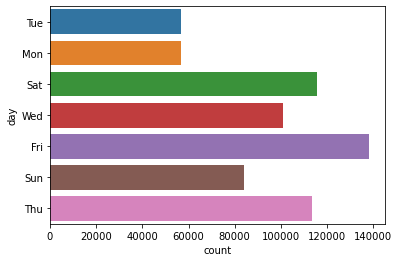

In [90]:
sns.countplot(y='day', data=df)

In [29]:
df.drop(['day'], axis=1,inplace=True)

## Avg response time by company


In [31]:
#In order to calculate average Tweet response times by companies, we do not require preprocessing hence loading the data file again and focusing on tweet creation and response times
tweets_raw = pd.read_csv("twcs.csv", low_memory=False)

In [32]:
#Understanding the size of the original dataframe
tweets_raw.shape

(1048575, 7)

In [33]:
#Getting info about the datafram
tweets_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   tweet_id                 1048575 non-null  int64  
 1   author_id                1048575 non-null  object 
 2   inbound                  1048575 non-null  bool   
 3   created_at               1048575 non-null  object 
 4   text                     1048575 non-null  object 
 5   response_tweet_id        683860 non-null   object 
 6   in_response_to_tweet_id  767999 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(4)
memory usage: 49.0+ MB


In [34]:
tweets_raw.head()

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [35]:
#Separating the original dataframe into inbounds and outbounds
inbounds = tweets_raw.loc[tweets_raw['inbound'] == True]
outbounds = tweets_raw.loc[tweets_raw['inbound'] == False]

#Merging/joining to be able to later find time between responses. Messy as a variable because the table looks so messy.
messy = pd.merge(outbounds, inbounds, left_on='in_response_to_tweet_id', right_on='tweet_id', how='outer')

#Changing timestamp format
messy['outbound_time'] = pd.to_datetime(messy['created_at_x'], format='%a %b %d %H:%M:%S +0000 %Y')
messy['inbound_time'] = pd.to_datetime(messy['created_at_y'], format='%a %b %d %H:%M:%S +0000 %Y')

#Calculating time between between outbound response and inbound message
messy['response_time'] = messy['outbound_time'] - messy['inbound_time']

messy.head()

,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y,outbound_time,inbound_time,response_time
0,1.0,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0,3.0,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0,2017-10-31 22:10:47,2017-10-31 22:08:27,0 days 00:02:20
1,4.0,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0,5.0,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0,2017-10-31 21:54:49,2017-10-31 21:49:35,0 days 00:05:14
2,6.0,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0,8.0,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,2017-10-31 21:46:24,2017-10-31 21:45:10,0 days 00:01:14
3,11.0,sprintcare,False,Tue Oct 31 22:10:35 +0000 2017,@115713 This is saddening to hear. Please shoo...,NaN,12.0,12.0,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0,2017-10-31 22:10:35,2017-10-31 22:04:47,0 days 00:05:48
4,13.0,sprintcare,False,Wed Nov 01 20:48:14 +0000 2017,@115713 I would really like to work with you t...,NaN,12.0,12.0,115713,True,Tue Oct 31 22:04:47 +0000 2017,@sprintcare You gonna magically change your co...,"11,13,14",15.0,2017-11-01 20:48:14,2017-10-31 22:04:47,0 days 22:43:27


In [36]:
#Making sure the data type is a timedelta/duration
print('from ' + str(messy['response_time'].dtype))

#Making it easier to later do averages by converting to a float datatype
messy['converted_time'] = messy['response_time'].astype('timedelta64[s]') / 60

print('to ' + str(messy['converted_time'].dtype))

from timedelta64[ns]
to float64


In [37]:
# Getting the average response time per company for the Top 35 companies with shortest response time
messy.groupby('author_id_x')['converted_time'].mean().nsmallest(10)

author_id_x
AlaskaAir           6.591989
VirginAmerica       6.646946
VerizonSupport      8.707615
LondonMidland       8.754196
nationalrailenq    12.043567
TMobileHelp        13.498510
TwitterSupport     16.240727
IHGService         21.913752
AmericanAir        22.459771
PearsonSupport     25.172724
Name: converted_time, dtype: float64

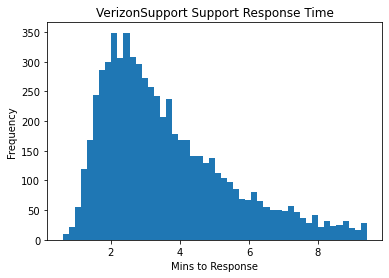

VerizonSupport's average response time is 3.61 minutes.


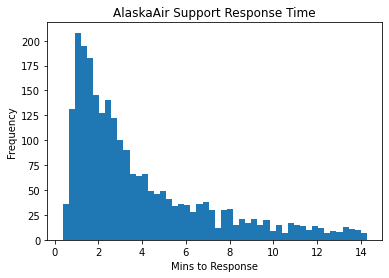

AlaskaAir's average response time is 3.89 minutes.


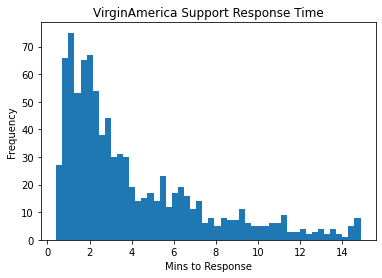

VirginAmerica's average response time is 4.01 minutes.


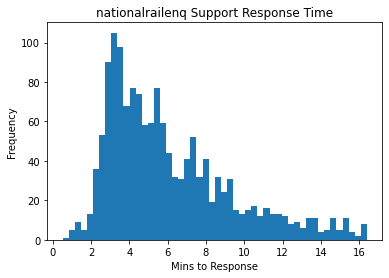

nationalrailenq's average response time is 6.07 minutes.


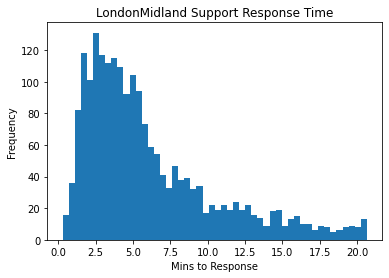

LondonMidland's average response time is 6.08 minutes.


In [38]:
columns = ['VerizonSupport','AlaskaAir','VirginAmerica','nationalrailenq','LondonMidland']

def graphs(column):
    times = messy[messy['author_id_x'] == column]['converted_time']
    times.dropna(inplace=True)

    def remove_outlier(times):
        q1 = times.quantile(0.25)
        q3 = times.quantile(0.75)
        iqr = q3-q1 #Interquartile range
        fence_low  = q1-1.5*iqr
        fence_high = q3+1.5*iqr
        df_out = times.loc[(times > fence_low) & (times < fence_high)]
        return df_out

    no_outliers = remove_outlier(times)

    hist_plot = no_outliers.plot.hist(bins=50)
    hist_plot.set_title(column + ' Support Response Time')
    hist_plot.set_xlabel('Mins to Response')
    hist_plot.set_ylabel('Frequency')
    plt.show()

    print(column+'\'s average response time is ' + str(round(no_outliers.mean(),2)) + ' minutes.')
    
for col in columns:
    graphs(col)

## Findings
    - Verizon Support is the company with the fastest response time for complaint tweets

## Sentiment change after interaction with company

In [49]:
columns = ['VerizonSupport','AlaskaAir','VirginAmerica','nationalrailenq','LondonMidland']

def printSentiment(column):    
    column_1 = df[df['company'] == column]
    print (column,'\n')
    print('Initial Tweet Sentiment', round(column_1[column_1['type'] == 'inbound'].sent.mean(),4))
    print('Change in Sentiment after interacting with company', \
          round(column_1[column_1['type'] == 'responses'].sent.mean() - column_1[column_1['type'] == 'inbound'].sent.mean(),4))
    print('Company Tweet sentiment', round(column_1[column_1['type'] == 'company'].sent.mean(),4),'\n')
    
for col in columns:
    printSentiment(col)

VerizonSupport 

Initial Tweet Sentiment -0.0625
Change in Sentiment after interacting with company 0.1079
Company Tweet sentiment 0.2208 

AlaskaAir 

Initial Tweet Sentiment 0.2349
Change in Sentiment after interacting with company 0.0115
Company Tweet sentiment 0.414 

VirginAmerica 

Initial Tweet Sentiment 0.0991
Change in Sentiment after interacting with company -0.0397
Company Tweet sentiment 0.2955 

nationalrailenq 

Initial Tweet Sentiment -0.0539
Change in Sentiment after interacting with company 0.1855
Company Tweet sentiment 0.0663 

LondonMidland 

Initial Tweet Sentiment -0.0478
Change in Sentiment after interacting with company 0.1103
Company Tweet sentiment 0.0022 



# LDA Modeling

In [81]:
def lda_model(df, topics, print_top):  
  T = []
  for x in df[df['sent'] < 0].text:
      T = T + [x.split()] 
      
  dictionary = corpora.Dictionary(T)
  corpus = [dictionary.doc2bow(text) for text in T]

  lda = LdaModel(corpus, 
              id2word=dictionary, 
              num_topics=topics, 
              random_state=0, 
              iterations=100,
              passes=5,
              per_word_topics=False)

  x=lda.show_topics(num_topics=10, num_words=10,formatted=False)
  topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

  #Below Code Prints Topics and Words
  if print_top == True:
    for topic,words in topics_words:
        print(str(topic)+ "::"+ str(words))

  #Creating an unvectorized corpus for the coherence score function    
  text = [[dictionary[word_id] for word_id, freq in doc] for doc in corpus]


  return lda, dictionary, corpus, text

C:\Users\apalaciosvillagom\.conda\conda\envs\learn-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
columns = ['VerizonSupport','AlaskaAir','VirginAmerica','nationalrailenq','LondonMidland']

def column_ida(column):
    column_lda, column_dict, column_corpus, column_text = lda_model(column, 6, True)


C:\Users\apalaciosvillagom\.conda\conda\envs\learn-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Coherence Score

Reference:

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/


https://stackoverflow.com/questions/46282473/error-while-identify-the-coherence-value-from-lda-model

In [83]:
def coherence_graph(df, show_topics, max_topics, title):
  coherence_values = []

  for i in range(2, max_topics + 1):
    lda, diction, corpus, text = lda_model(df, i, show_topics)
    cm = CoherenceModel(model=lda, corpus = corpus, dictionary = diction, texts = text, coherence='c_v')
    coherence_values.append(cm.get_coherence())

  x = range(2, max_topics + 1)
  plt.plot(x, coherence_values)
  plt.title(title)
  plt.xlabel("Num Topics")
  plt.ylabel("Coherence score")
  plt.legend(("coherence_values"), loc='best')
  plt.show()
  print(coherence_values)

C:\Users\apalaciosvillagom\.conda\conda\envs\learn-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


C:\Users\apalaciosvillagom\.conda\conda\envs\learn-env\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


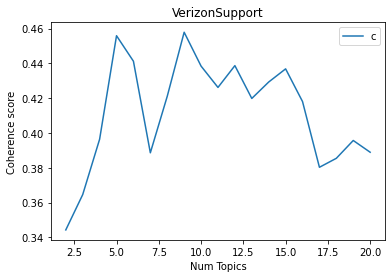

[0.3442440241640127, 0.3645355589127958, 0.39636579939838384, 0.45588808923689256, 0.44122204325076225, 0.38858198537168764, 0.42107802513800074, 0.45788657417497913, 0.4384308104547426, 0.4261612586178343, 0.4386909200715554, 0.4198238710281672, 0.42927034324246255, 0.4368327370031682, 0.41804627276469064, 0.3802567084970676, 0.38541429909004443, 0.3956583080858196, 0.3889027845609562]


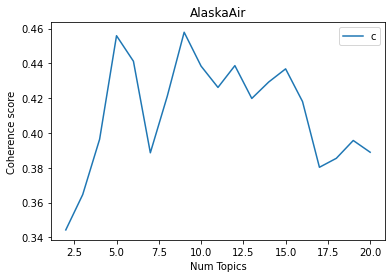

[0.3442440241640127, 0.3645355589127958, 0.39636579939838384, 0.45588808923689256, 0.44122204325076225, 0.38858198537168764, 0.42107802513800074, 0.45788657417497913, 0.4384308104547426, 0.4261612586178343, 0.4386909200715554, 0.4198238710281672, 0.42927034324246255, 0.4368327370031682, 0.41804627276469064, 0.3802567084970676, 0.38541429909004443, 0.3956583080858196, 0.3889027845609562]


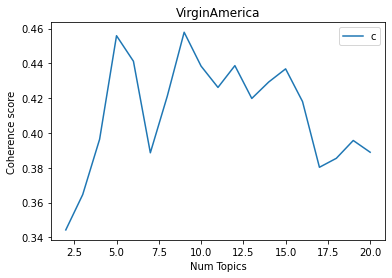

[0.3442440241640127, 0.3645355589127958, 0.39636579939838384, 0.45588808923689256, 0.44122204325076225, 0.38858198537168764, 0.42107802513800074, 0.45788657417497913, 0.4384308104547426, 0.4261612586178343, 0.4386909200715554, 0.4198238710281672, 0.42927034324246255, 0.4368327370031682, 0.41804627276469064, 0.3802567084970676, 0.38541429909004443, 0.3956583080858196, 0.3889027845609562]


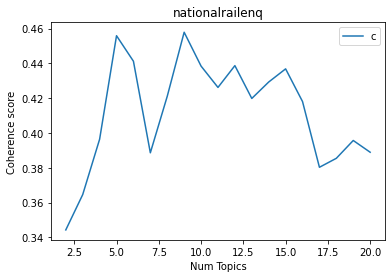

[0.3442440241640127, 0.3645355589127958, 0.39636579939838384, 0.45588808923689256, 0.44122204325076225, 0.38858198537168764, 0.42107802513800074, 0.45788657417497913, 0.4384308104547426, 0.4261612586178343, 0.4386909200715554, 0.4198238710281672, 0.42927034324246255, 0.4368327370031682, 0.41804627276469064, 0.3802567084970676, 0.38541429909004443, 0.3956583080858196, 0.3889027845609562]


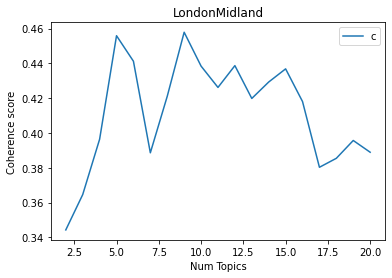

[0.3442440241640127, 0.3645355589127958, 0.39636579939838384, 0.45588808923689256, 0.44122204325076225, 0.38858198537168764, 0.42107802513800074, 0.45788657417497913, 0.4384308104547426, 0.4261612586178343, 0.4386909200715554, 0.4198238710281672, 0.42927034324246255, 0.4368327370031682, 0.41804627276469064, 0.3802567084970676, 0.38541429909004443, 0.3956583080858196, 0.3889027845609562]


In [84]:
columns = ['VerizonSupport','AlaskaAir','VirginAmerica','nationalrailenq','LondonMidland']

def coherence_graphs(column):
    coherence_graph(df[df['type'] == 'inbound'], False, 20, column)

for col in columns:
    coherence_graphs(col)

# Conclusion

The sentiment analysis model presented in this project provides valuable insights into customer feedback and sentiment for businesses. By identifying the top 10 companies with the most complaints and analyzing their response times and change in sentiment after interacting with customers, stakeholders can take proactive measures to improve the overall customer experience and address underlying issues that lead to negative feedback.

The implications of this project for the real-world problem of tracking and analyzing customer feedback are significant. By utilizing sentiment analysis, companies can improve customer satisfaction, loyalty, and overall business performance. Stakeholders, including company executives, customer service teams, marketing teams, and product development teams, can use the insights from this project to make strategic decisions and take targeted actions to address customer concerns and improve the overall customer experience.

Overall, the sentiment analysis model presented in this project has the potential to make a significant impact on businesses' ability to understand and address customer feedback. The insights provided by the model can help companies improve customer satisfaction, increase loyalty, and ultimately drive business growth.